In [168]:
import pandas as pd
import matplotlib.pyplot as plt
import time
from ast import literal_eval
from IPython import display
import numpy as np
import matplotlib.pyplot as plt


In [195]:
data = pd.read_csv('history.csv')

print('number of episodes finished %d'%len(data))


number of episodes finished 87206


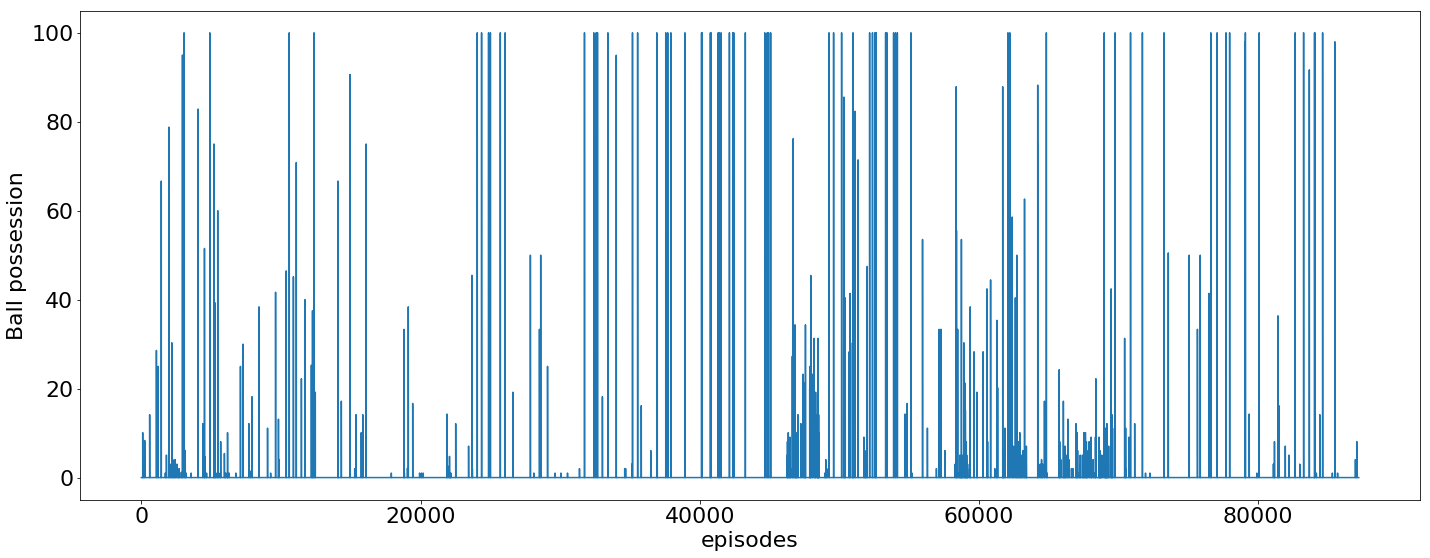

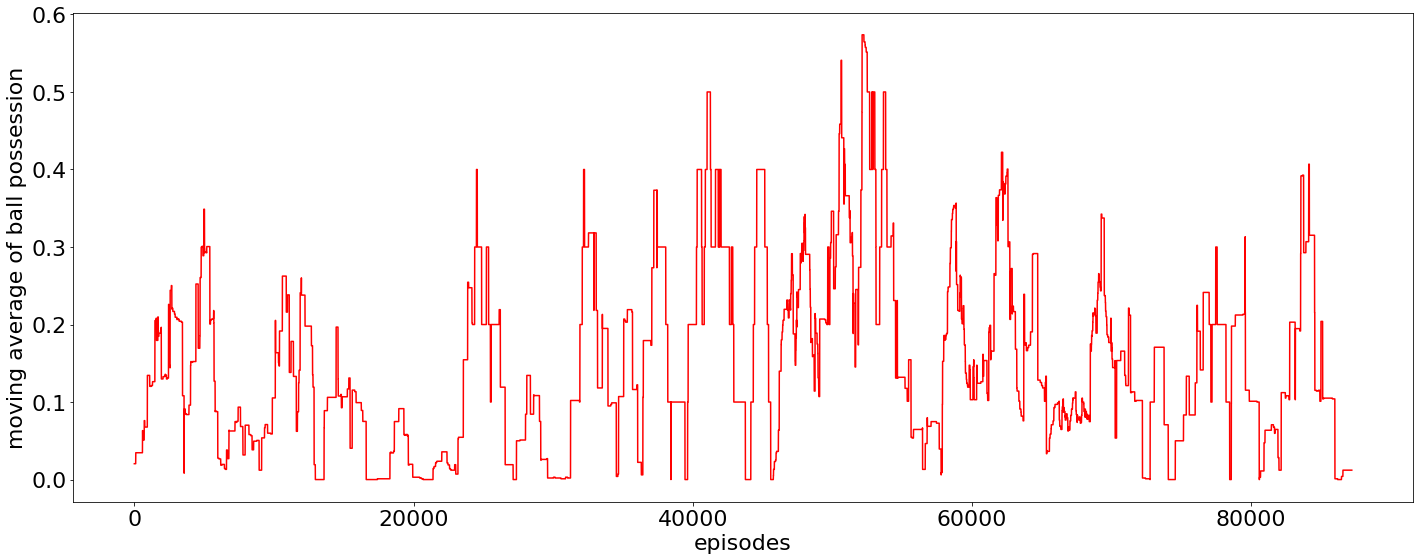

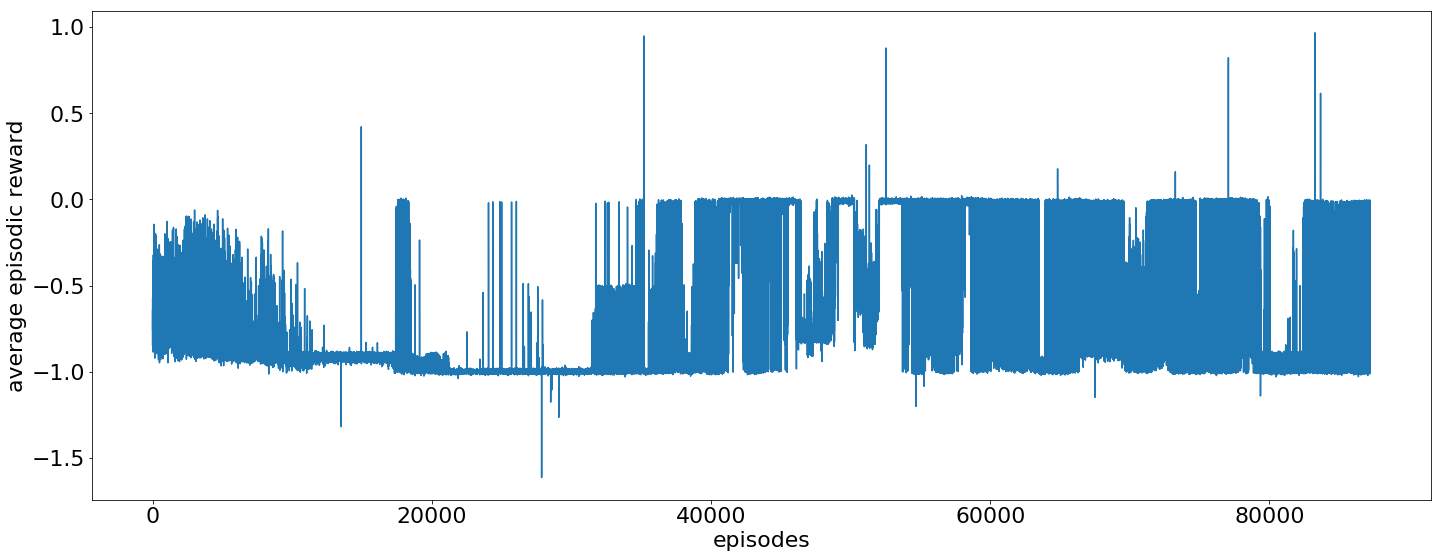

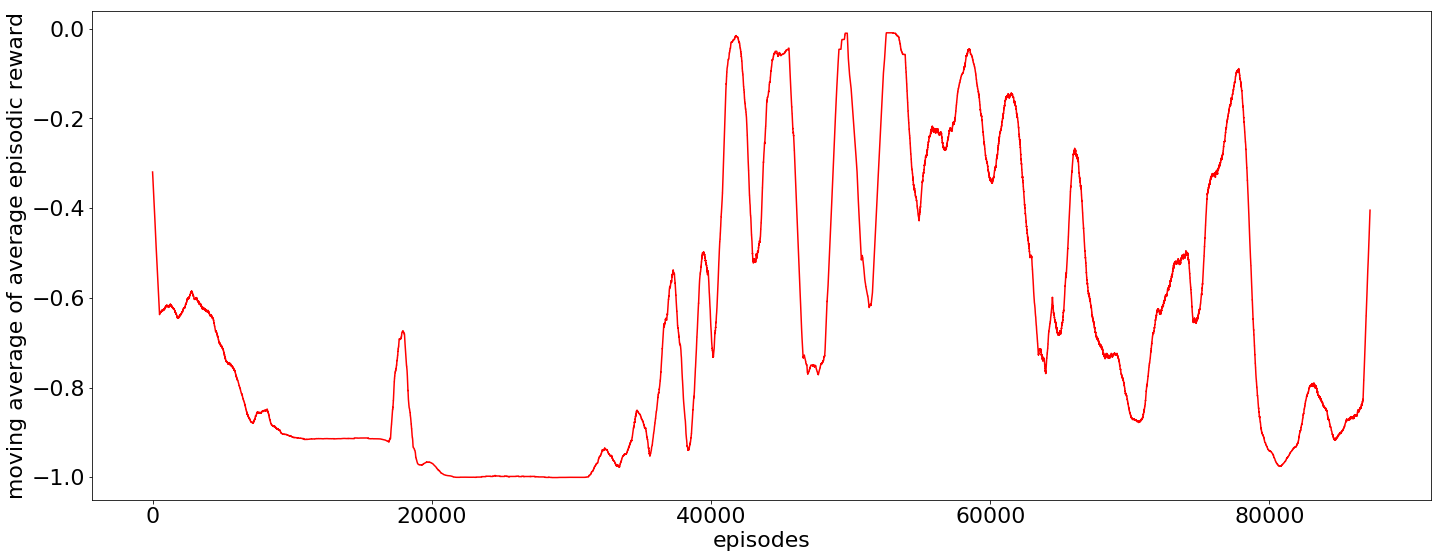

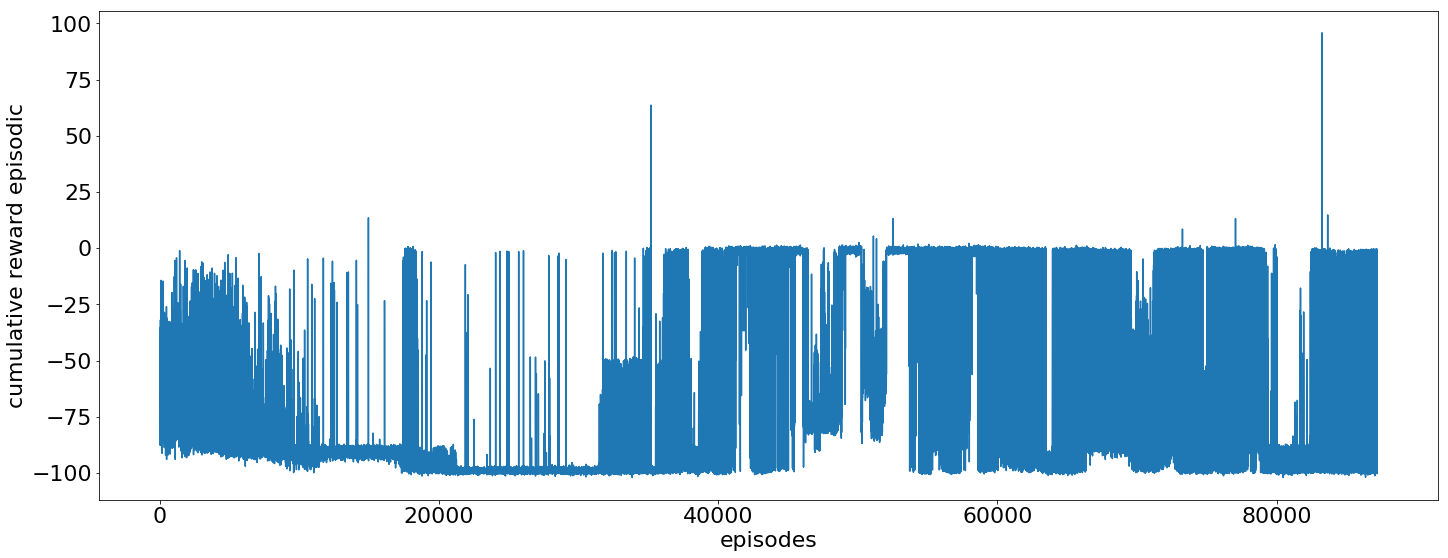

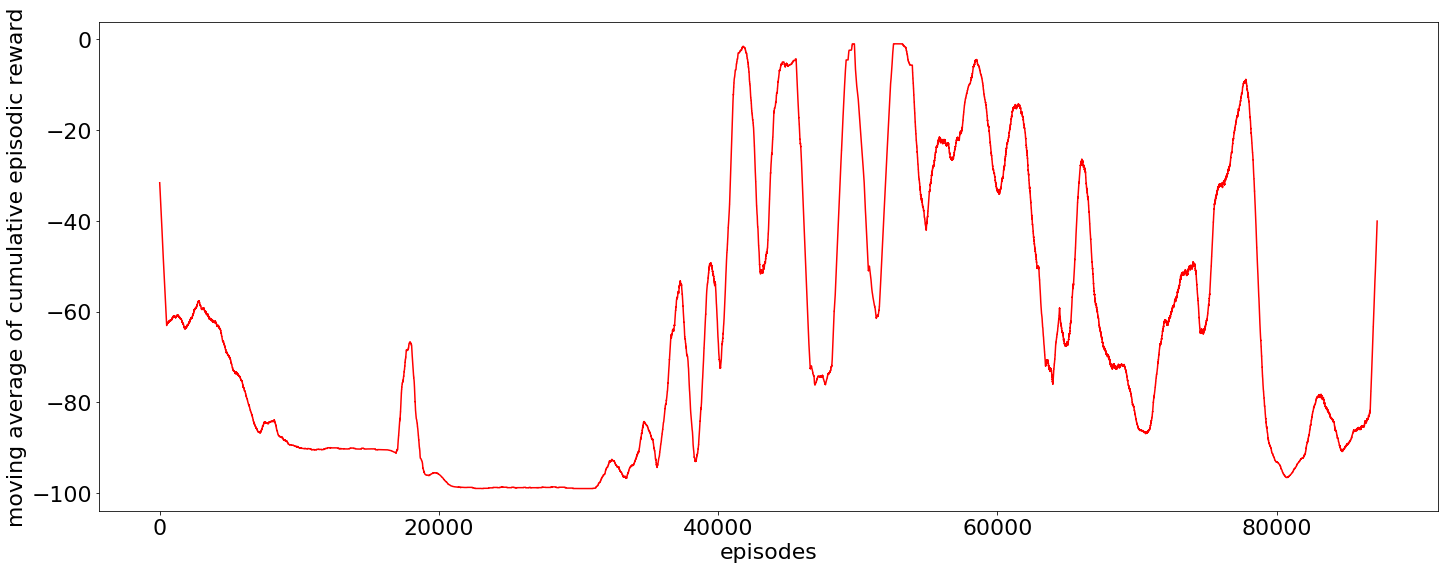

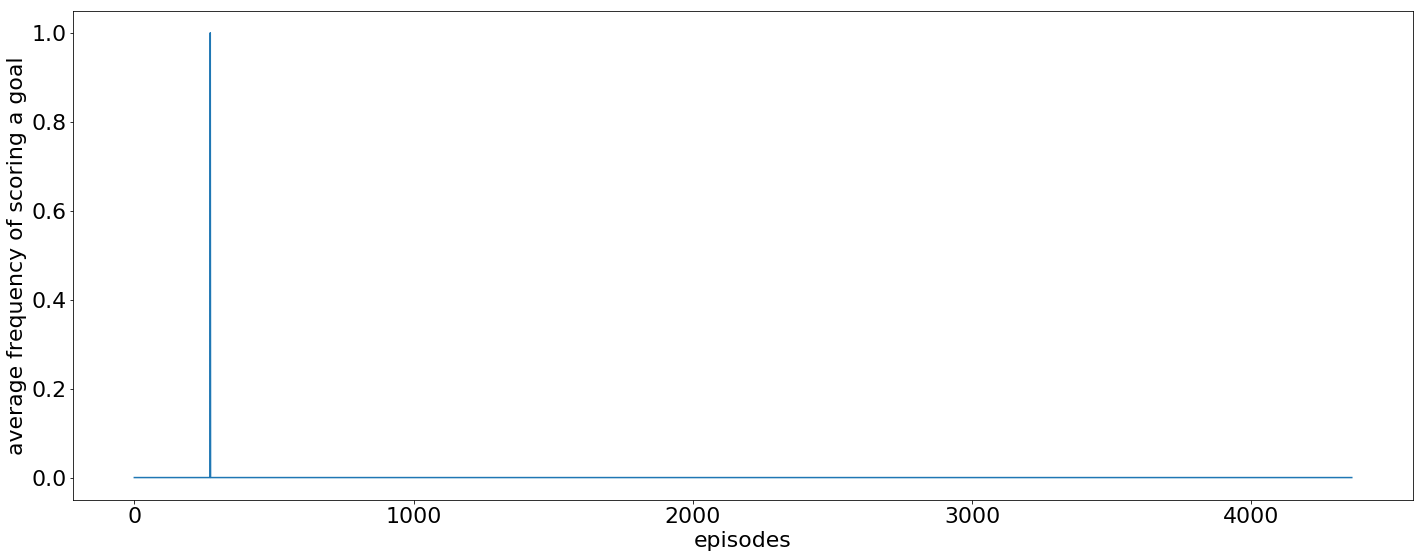

OutOfTime      87107
OutOfBounds       98
Goal               1
Name: why, dtype: int64

In [196]:
goal_frequency_window = 20

######################################---ball possession  and smoothed curve---#########################################################

plt.rcParams.update({'font.size': 22})
plt.figure(figsize=(24,9))
plt.plot(data.kickable_percentages  )
plt.xlabel('episodes')
plt.ylabel('Ball possession')
plt.show()

plt.rcParams.update({'font.size': 22})
plt.figure(figsize=(24,9))
plt.plot( np.convolve(data.kickable_percentages, np.ones((1000,))/1000, mode='same'), '-r' )
plt.xlabel('episodes')
plt.ylabel('moving average of ball possession')
plt.show()


######################################--- average episodic reward and smoothed curve-----#########################################################
reward = []
for i in range(len(data)):
    reward.append(literal_eval(data.average_reward[i]))
plt.rcParams.update({'font.size': 22})
plt.figure(figsize=(24,9))
plt.plot(reward)
plt.xlabel('episodes')
plt.ylabel('average episodic reward')
plt.show()

plt.rcParams.update({'font.size': 22})
plt.figure(figsize=(24,9))
plt.plot( np.convolve(np.ravel(reward) , np.ones((1000,))/1000, mode='same'), '-r' )
plt.xlabel('episodes')
plt.ylabel('moving average of average episodic reward')
plt.show()
######################################--- cumulative episodic reward and smoothed curve-----#########################################################

reward = []
for i in range(len(data)):
    reward.append(literal_eval(data.cumulative_reward[i]))
plt.rcParams.update({'font.size': 22})
plt.figure(figsize=(24,9))
plt.plot(reward)
plt.xlabel('episodes')
plt.ylabel('cumulative reward episodic')
plt.show()


plt.rcParams.update({'font.size': 22})
plt.figure(figsize=(24,9))
plt.plot( np.convolve(np.ravel(reward) , np.ones((1000,))/1000, mode='same'), '-r' )
plt.xlabel('episodes')
plt.ylabel('moving average of cumulative episodic reward')
plt.show()

#####################################################


goal_freq = []
for i in range(0, len(data), goal_frequency_window):
    temp = data.loc[i:i+goal_frequency_window].why.value_counts()
    
    try: 
        goal_freq.append(temp.Goal)
    except AttributeError:
        goal_freq.append(0)
        
plt.rcParams.update({'font.size': 22})
plt.figure(figsize=(24,9))
plt.plot(goal_freq)
plt.xlabel('episodes')
plt.ylabel('average frequency of scoring a goal')
plt.show()
        
data.why.value_counts()

In [197]:
fname = 'log/base_left-11.log'
with open(fname) as f:
    content = f.readlines()
# you may also want to remove whitespace characters like `\n` at the end of each line
content = [x.strip() for x in content] 

In [198]:
#content

In [199]:
GameStates = 0
StateFeatures = 0
actions = 0
for i in range(len(content)):
    if content[i].split(' ')[3] == 'GameStatus':
        GameStates+=1
    elif content[i].split(' ')[3] == 'StateFeatures':
        StateFeatures +=1
    else:#if content[i].split(' ')[3] =='/home.sda4/home/ssajjadi/Desktop/ML/work/HFO-master/build/librcsc-prefix/src/librcsc/rcsc/player/player_agent.cpp:':
        actions+=1

In [202]:
print('number of observed Game states as --GameStatus--: ', GameStates)
print('number of observed Game states as --:StateFeatures--: ', StateFeatures)
print('number of valid actions taken in the env: ' ,actions)

number of observed Game states as --GameStatus--:  8892649
number of observed Game states as --:StateFeatures--:  8892649
number of valid actions taken in the env:  2969642
